# Studying Mapping and Routing Libraries
## A machine learning course project using data from Wolt

In this notebook, I work with the same food delivery data from Wolt. I play around with Python's mapping and routing libraries OSMnx and NetworkX, which I was not familiar with before.

## Importing packages and reading the data

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import osmnx as ox
import plotly.graph_objects as go
from datetime import date
import calendar
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.lines import Line2D
import math

In [2]:
print(f"The NetworkX package is version {nx.__version__}")
print(f"The OSMNX package is version {ox.__version__}")

The NetworkX package is version 2.6.3
The OSMNX package is version 1.0.1


## Read the data

In [3]:
orders2020 = pd.read_csv("orders_autumn_2020.csv")

In [4]:
orders = orders2020
orders = orders.rename(columns={'ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES': 'EST_ERROR', 
                                'ITEM_COUNT':'ITEMS', 'ESTIMATED_DELIVERY_MINUTES': 'EST_MIN', 
                                'ACTUAL_DELIVERY_MINUTES': 'ACT_MIN', 'CLOUD_COVERAGE':'CLOUDS', 
                                'TEMPERATURE':'TEMP','WIND_SPEED':'WIND','PRECIPITATION':'RAIN'})

orders = orders[['TIMESTAMP','EST_ERROR','EST_MIN',
                 'ACT_MIN','ITEMS','USER_LAT',
                 'USER_LONG','VENUE_LAT','VENUE_LONG',
                 'TEMP','CLOUDS','RAIN','WIND']]

In [5]:
orders.head(2)

TIMESTAMP  EST_ERROR  EST_MIN  ACT_MIN  ITEMS  USER_LAT  \
0  2020-08-01 06:07:00.000        -19       29       10      1    60.158   
1  2020-08-01 06:17:00.000         -7       39       32      8    60.163   

   USER_LONG  VENUE_LAT  VENUE_LONG  TEMP  CLOUDS  RAIN     WIND  
0     24.946     60.160      24.946  15.0     0.0   0.0  3.53644  
1     24.927     60.153      24.910  15.0     0.0   0.0  3.53644

## Distances between users and venues by road

To determine distances, we need get a graph that depicts the geographical area in Helsinki that we are studying. Then we need to find the nearest nodes to our users and venues on that graph. We then calculate the distances between these nodes that best approximate our location data.

First we collect the coordinates for users and venues. We drop duplicates to see how many unique locations there are.

In [6]:
coordinates = orders.loc[:,['USER_LAT','USER_LONG','VENUE_LAT','VENUE_LONG']] # Used for maps
users = coordinates.loc[:,['USER_LAT','USER_LONG']]
venues = coordinates.loc[:,['VENUE_LAT','VENUE_LONG']]
user_points = users.drop_duplicates().reset_index(drop=True)
venue_points = venues.drop_duplicates().reset_index(drop=True)

Based on all of the coordinates found in our dataset, we set the following limits for our map (which should accomodate all our nodes):

In [7]:
south = round(min(min(user_points.USER_LAT),min(venue_points.VENUE_LAT)),2)-0.02
north = round(max(max(user_points.USER_LAT),max(venue_points.VENUE_LAT)),2)+0.02
west = round(min(min(user_points.USER_LONG),min(venue_points.VENUE_LONG)),2)-0.02
east = round(max(max(user_points.USER_LONG),max(venue_points.VENUE_LONG)),2)+0.02

In [8]:
south, north, west, east

(60.129999999999995, 60.24, 24.86, 25.06)

Our order data is from downtown Helsinki. Now we get the graph that depicts this area.

In [9]:
#G_all = ox.graph_from_bbox(north, south, east, west, network_type='all')
G_drive = ox.graph_from_bbox(north, south, east, west, network_type='drive')

## Distances between user and node pairs

Each order creates a pair of the user coordinates (point) and the corresponding node on the graph.

In [10]:
user_venue_pairs = orders.loc[:,['USER_LAT','USER_LONG','VENUE_LAT','VENUE_LONG']].drop_duplicates().reset_index(drop=True)
user_venue_pairs['USER'] = list(zip(user_venue_pairs.USER_LAT,user_venue_pairs.USER_LONG))
user_venue_pairs['VENUE'] = list(zip(user_venue_pairs.VENUE_LAT,user_venue_pairs.VENUE_LONG))
user_venue_pairs

USER_LAT  USER_LONG  VENUE_LAT  VENUE_LONG              USER  \
0        60.158     24.946     60.160      24.946  (60.158, 24.946)   
1        60.163     24.927     60.153      24.910  (60.163, 24.927)   
2        60.161     24.937     60.162      24.939  (60.161, 24.937)   
3        60.185     24.954     60.190      24.911  (60.185, 24.954)   
4        60.182     24.955     60.178      24.949  (60.182, 24.955)   
...         ...        ...        ...         ...               ...   
15896    60.183     24.910     60.163      24.941   (60.183, 24.91)   
15897    60.168     24.967     60.164      24.944  (60.168, 24.967)   
15898    60.159     24.949     60.163      24.941  (60.159, 24.949)   
15899    60.186     24.949     60.188      24.956  (60.186, 24.949)   
15900    60.166     24.965     60.183      24.951  (60.166, 24.965)   

                  VENUE  
0       (60.16, 24.946)  
1       (60.153, 24.91)  
2      (60.162, 24.939)  
3       (60.19, 24.911)  
4      (60.178, 24.949)  
...                 ...  
15896  (60.163, 24.941)  
15897  (60.164, 24.944)  
15898  (60.163, 24.941)  
15899  (60.188, 24.956)  
15900  (60.183, 24.951)  

[15901 rows x 6 columns]

In [11]:
user_coordinate_tuples = user_venue_pairs['USER'].drop_duplicates().reset_index(drop=True)
venue_coordinate_tuples = user_venue_pairs['VENUE'].drop_duplicates().reset_index(drop=True)
print(len(user_coordinate_tuples))
print(len(venue_coordinate_tuples))

2045
331


In [12]:
# Find nearest nodes for both
#G = G_all
G = G_drive
user_nodes = np.empty(len(user_coordinate_tuples))
venue_nodes = np.empty(len(venue_coordinate_tuples))

for i in range(len(user_coordinate_tuples)):
    #user_nodes[i]=(get_nodes(G, user_coordinate_tuples[i]))
    user_nodes[i] = ox.get_nearest_node(G, user_coordinate_tuples[i])
    
for i in range(len(venue_coordinate_tuples)):
    #venue_nodes[i] = (get_nodes(G, venue_coordinate_tuples[i]))
    venue_nodes[i] = ox.get_nearest_node(G, venue_coordinate_tuples[i])

In [13]:
user_nodes = user_nodes.astype(int)
venue_nodes = venue_nodes.astype(int)
user_nodes = pd.DataFrame(user_nodes, columns=['USER_NODE'])
venue_nodes = pd.DataFrame(venue_nodes, columns=['VENUE_NODE'])

In [14]:
user_points = user_venue_pairs.loc[:,['USER_LAT','USER_LONG']].drop_duplicates().reset_index(drop=True)
venue_points = user_venue_pairs.loc[:,['VENUE_LAT','VENUE_LONG']].drop_duplicates().reset_index(drop=True)

In [15]:
user_points_and_nodes = pd.DataFrame({'USER_LAT':user_points.USER_LAT,'USER_LONG':user_points.USER_LONG,'USER_NODE':user_nodes.values.reshape(len(user_nodes),)})
venue_points_and_nodes = pd.DataFrame({'VENUE_LAT':venue_points.VENUE_LAT,'VENUE_LONG':venue_points.VENUE_LONG,'VENUE_NODE':venue_nodes.values.reshape(len(venue_nodes),)})

In [16]:
user_points_and_nodes.head(2)

USER_LAT  USER_LONG   USER_NODE
0    60.158     24.946  1379550344
1    60.163     24.927   268177652

In [17]:
venue_points_and_nodes.head(2)

VENUE_LAT  VENUE_LONG  VENUE_NODE
0     60.160      24.946  1379089494
1     60.153      24.910 -2147483648

## Joining the dataframes user_venue_pairs, user_points_and_nodes, venue_points_and_nodes

We have the dataframes 

- user_venue_pairs, which has separate coordinates and coordinate tuples for users and venues,
- user_points_and_nodes, which has separate coordinates and the matching nodes for users, and
- venue_points_and_nodes, which has separate coordinates and the matching nodes for venues.

These should be merged based on the separate coordinates (columns USER_LAT, USER_LONG, VENUE_LAT, VENUE_LONG).

In [18]:
user_venue_pairs = pd.merge(user_venue_pairs,user_points_and_nodes,how='left',on=['USER_LAT','USER_LONG'])
user_venue_pairs = pd.merge(user_venue_pairs,venue_points_and_nodes,how='left',on=['VENUE_LAT','VENUE_LONG'])
user_venue_pairs

USER_LAT  USER_LONG  VENUE_LAT  VENUE_LONG              USER  \
0        60.158     24.946     60.160      24.946  (60.158, 24.946)   
1        60.163     24.927     60.153      24.910  (60.163, 24.927)   
2        60.161     24.937     60.162      24.939  (60.161, 24.937)   
3        60.185     24.954     60.190      24.911  (60.185, 24.954)   
4        60.182     24.955     60.178      24.949  (60.182, 24.955)   
...         ...        ...        ...         ...               ...   
15896    60.183     24.910     60.163      24.941   (60.183, 24.91)   
15897    60.168     24.967     60.164      24.944  (60.168, 24.967)   
15898    60.159     24.949     60.163      24.941  (60.159, 24.949)   
15899    60.186     24.949     60.188      24.956  (60.186, 24.949)   
15900    60.166     24.965     60.183      24.951  (60.166, 24.965)   

                  VENUE   USER_NODE  VENUE_NODE  
0       (60.16, 24.946)  1379550344  1379089494  
1       (60.153, 24.91)   268177652 -2147483648  
2      (60.162, 24.939)  1372260491    25291570  
3       (60.19, 24.911)   262985434  1514876728  
4      (60.178, 24.949)   269167184   247335167  
...                 ...         ...         ...  
15896  (60.163, 24.941)  1514876376   426911740  
15897  (60.164, 24.944)    30555902  1005526490  
15898  (60.163, 24.941)    25469526   426911740  
15899  (60.188, 24.956)  1525997612  1525450291  
15900  (60.183, 24.951)    30556088  1529213909  

[15901 rows x 8 columns]

Note that this dataframe only includes unique combinations of users and venues found in the dataframe orders, which is larger by approximately 3000 rows.

In [19]:
user_venue_pairs.shape

(15901, 8)

In [20]:
orders.shape

(18706, 13)

## The distances

Now we want a final column for distance. This is based on USER_NODE and VENUE_NODE.

The function get_distance works for one row, not columns.

In [21]:
def get_distance(row):
    venue = row['USER_NODE']
    user = row['VENUE_NODE']
    try:
        dist = nx.shortest_path_length(G, venue, user, weight='length')
    except:
        dist = None
    return dist

In [22]:
user_venue_pairs['DISTANCE_BY_ROAD'] = user_venue_pairs.apply(get_distance, axis=1)

In [23]:
user_venue_pairs

USER_LAT  USER_LONG  VENUE_LAT  VENUE_LONG              USER  \
0        60.158     24.946     60.160      24.946  (60.158, 24.946)   
1        60.163     24.927     60.153      24.910  (60.163, 24.927)   
2        60.161     24.937     60.162      24.939  (60.161, 24.937)   
3        60.185     24.954     60.190      24.911  (60.185, 24.954)   
4        60.182     24.955     60.178      24.949  (60.182, 24.955)   
...         ...        ...        ...         ...               ...   
15896    60.183     24.910     60.163      24.941   (60.183, 24.91)   
15897    60.168     24.967     60.164      24.944  (60.168, 24.967)   
15898    60.159     24.949     60.163      24.941  (60.159, 24.949)   
15899    60.186     24.949     60.188      24.956  (60.186, 24.949)   
15900    60.166     24.965     60.183      24.951  (60.166, 24.965)   

                  VENUE   USER_NODE  VENUE_NODE  DISTANCE_BY_ROAD  
0       (60.16, 24.946)  1379550344  1379089494           224.983  
1       (60.153, 24.91)   268177652 -2147483648               NaN  
2      (60.162, 24.939)  1372260491    25291570           249.272  
3       (60.19, 24.911)   262985434  1514876728          2977.817  
4      (60.178, 24.949)   269167184   247335167           500.422  
...                 ...         ...         ...               ...  
15896  (60.163, 24.941)  1514876376   426911740          3748.357  
15897  (60.164, 24.944)    30555902  1005526490          1951.867  
15898  (60.163, 24.941)    25469526   426911740           951.171  
15899  (60.188, 24.956)  1525997612  1525450291           717.098  
15900  (60.183, 24.951)    30556088  1529213909          2733.379  

[15901 rows x 9 columns]

<font color=red>There were some failures to count distances between node pairs. This seems to stem from some nodes having a negative sign. Apparently these nodes can't be reached on the graph.
    
Here is how many rows have null as the distance measure:</font>

In [24]:
print(f"Distance couldn't be calculated for {user_venue_pairs.shape[0]-user_venue_pairs.dropna().shape[0]} node pairs out of {user_venue_pairs.shape[0]} pairs")

Distance couldn't be calculated for 2343 node pairs out of 15901 pairs


## Merge new feature 'DISTANCE_BY_ROAD' to original dataframe 'orders'

In [25]:
orders = pd.merge(orders,user_venue_pairs,how='left',on=['USER_LAT','USER_LONG','VENUE_LAT','VENUE_LONG'])

# Maps

Now we visualize the geospatial data given using a map of Helsinki. We'll map the area and look at the distribution of the datapoints.

Every order in the provided file has a pick-up and a drop-off location, and they are connected via a route on a map. OpenStreetMap has the suitable map data, and you can use tools such as OSMnx and NetworkX to utilize it.

## Map of downtown Helsinki

Here's a map with only roads you can drive on.

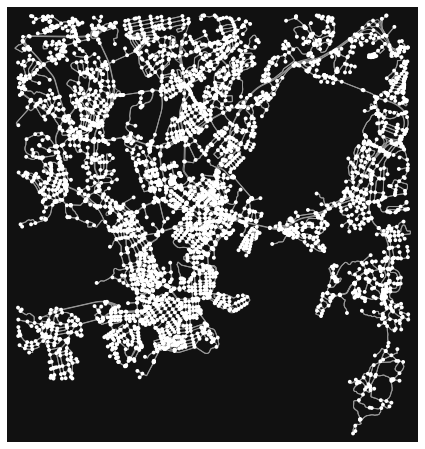

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [26]:
G_drive = ox.graph_from_bbox(north, south, east, west, network_type='drive', simplify=True)
#G_drive_projected = ox.project_graph(G_drive)
#ox.plot_graph(G_drive_projected)
ox.plot_graph(G_drive)

## Let's make the map prettier

Now, we should give different colors to different kinds of roads.

Also colors for nodes (green for venue, red for user)?

In [27]:
u = []
v = []
key = []
data = []
G = G_drive
for uu, vv, kkey, ddata in G.edges(keys=True, data=True):
    u.append(uu)
    v.append(vv)
    key.append(kkey)
    data.append(ddata)  

In [28]:
data[0]

{'osmid': [55449400, 18467152, 18467158],
 'lanes': '2',
 'name': 'Kuusisaarentie',
 'highway': 'secondary',
 'maxspeed': '50',
 'oneway': False,
 'length': 296.271,
 'bridge': 'yes',
 'geometry': <shapely.geometry.linestring.LineString at 0x2084c9b7b80>}

In [29]:
# List to store colors
roadColors = []

# The length is in meters
for item in data:
    if "highway" in item.keys():
        
        if item["highway"] == "primary":
            color = "#ff5ecf"
            
        elif item["highway"] == "secondary":
            color = "#ffe882"
            
        elif item["highway"] == "tertiary":
            color = "#94c9ff"
            
        else:
            color = "w"
             
    roadColors.append(color)

# List to store linewidths
roadWidths = []

for item in data:
    if item["highway"] == "residential":
        linewidth = 1

    else:
        linewidth = 2.5
        
    roadWidths.append(linewidth)

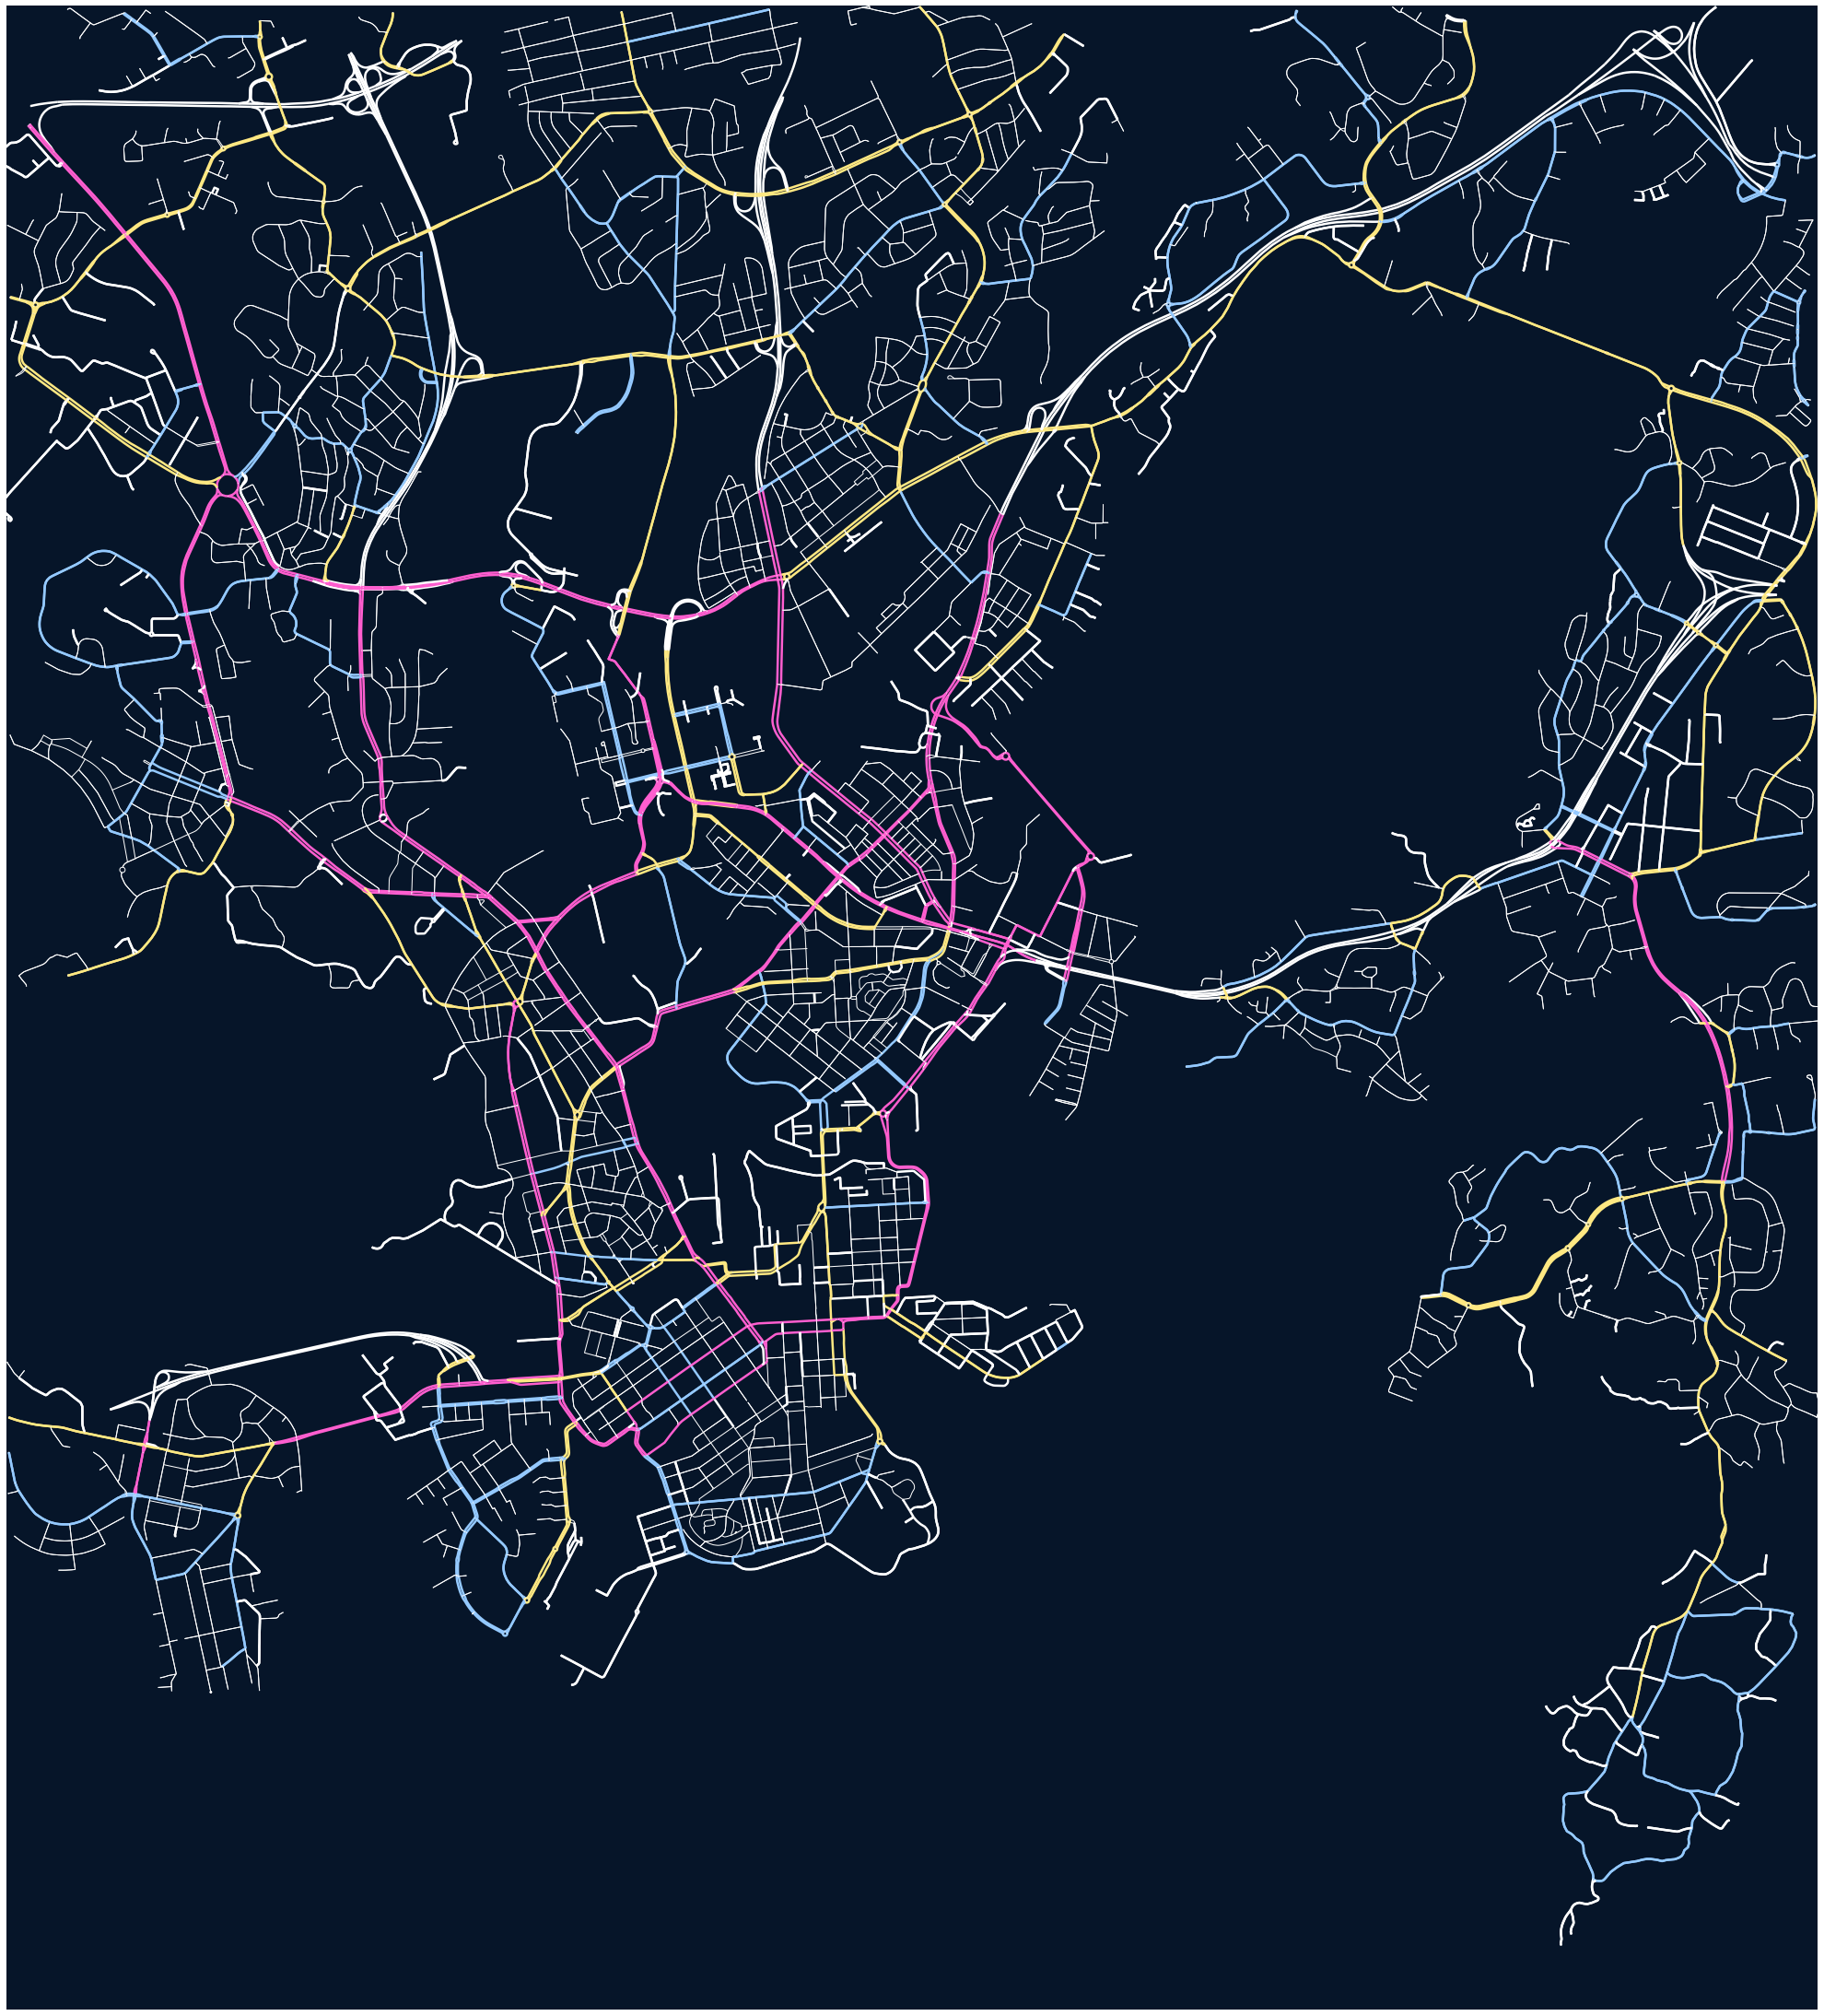

In [30]:
#G_drive = ox.graph_from_bbox(north, south, east, west, network_type='drive', simplify=True)
#G_drive_projected = ox.project_graph(G_drive)
fig, ax = ox.plot_graph(G, 
                        node_size=1, 
                        bbox = (north, south, east, west), 
                        figsize=(40,40),
                        dpi = 300,  
                        bgcolor = "#061529",
                        save = False, 
                        edge_color=roadColors,
                        edge_linewidth=roadWidths, 
                        edge_alpha=1)

# Text and marker size
markersize = 16
fontsize = 16

# Add legend
legend_elements = [Line2D([0], [0], marker='s', color="#ff5ecf", label= 'Primary road',
                          markerfacecolor="#ff5ecf", markersize=markersize),
                          
                  Line2D([0], [0], marker='s', color="#ffe882", label= 'Secondary road',
                         markerfacecolor="#ffe882", markersize=markersize),
                  
                  Line2D([0], [0], marker='s', color="#94c9ff", label= 'Tertiary road',
                         markerfacecolor="#94c9ff", markersize=markersize),
                  
                  Line2D([0], [0], marker='s', color="#ffffff", label= 'Residential or unidentified road',
                  markerfacecolor="w", markersize=markersize)]    
                      
l = ax.legend(handles=legend_elements, bbox_to_anchor=(0, 0), 
              frameon=True, ncol=1,
              facecolor = '#061529', framealpha = 0.9,
              loc='lower left',  fontsize = fontsize, 
              prop={'family':"Georgia", 'size':fontsize})  
  
# Legend font color
for text in l.get_texts():
    text.set_color("w")

fig.savefig("Helsinki_transparent.png", dpi=300, bbox_inches='tight', format="png", facecolor=fig.get_facecolor(), transparent=True)


# Route optimization

## Function for finding optimal route

In [32]:
#def optimal_route():
    # TO DO

## One optimal route

Let's try optimizing the route between one user node and one venue node.

In [33]:
# Define user point and venue point
user_point = tuple(user_points.loc[100,:])
print(f"User location: {user_point}")
venue_point = tuple(venue_points.loc[100,:])
print(f"Venue location: {venue_point}")

# Find nearest nodes for both
user_node = ox.get_nearest_node(G_drive, user_point) 
print(f"Closest node to user location: {user_node}")
venue_node = ox.get_nearest_node(G_drive, venue_point) 
print(f"Closest node to venue location: {venue_node}")

# Finding the optimal path
route = nx.shortest_path(G, user_node, venue_node, weight = 'length') 
#route

User location: (60.168, 24.966)
Venue location: (60.187, 24.965)
Closest node to user location: 1009801691
Closest node to venue location: 1528653173


Let’s plot these nodes on a map. The following bit of code is from https://towardsdatascience.com/find-and-plot-your-optimal-path-using-plotly-and-networkx-in-python-17e75387b873.

In [34]:
# Getting coordinates of the nodes
# We will store the longitudes and latitudes in following list 
long = [] 
lat = []  
for i in route:
    point = G.nodes[i]
    long.append(point['x'])
    lat.append(point['y'])

In [35]:
def plot_path(lat, long, origin_point, destination_point):
    
    """
    Given a list of latitudes and longitudes, origin 
    and destination point, plots a path on a map
    
    Parameters
    ----------
    lat, long: list of latitudes and longitudes
    origin_point, destination_point: co-ordinates of origin
    and destination
    Returns
    -------
    Nothing. Only shows the map.
    """
    # adding the lines joining the nodes
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'blue')))
    # adding source marker
    fig.add_trace(go.Scattermapbox(
        name = "User",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
     
    # adding destination marker
    fig.add_trace(go.Scattermapbox(
        name = "Venue",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    
    # getting center for plots:
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    # defining the layout using mapbox_style
    fig.update_layout(mapbox_style="stamen-terrain",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                      mapbox = {
                          'center': {'lat': lat_center, 
                          'lon': long_center},
                          'zoom': 13})
    fig.show()

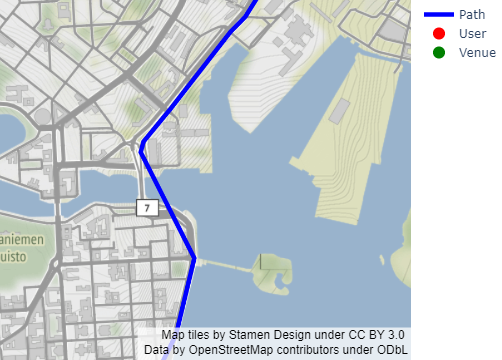

In [36]:
plot_path(lat, long, user_point, venue_point)

In [37]:
def node_list_to_path(G, node_list):
    """
    Given a list of nodes, return a list of lines that together
    follow the path
    defined by the list of nodes.
    Parameters
    ----------
    G : networkx multidigraph
    route : list
        the route as a list of nodes
    Returns
    -------
    lines : list of lines given as pairs ( (x_start, y_start), 
    (x_stop, y_stop) )
    """
    edge_nodes = list(zip(node_list[:-1], node_list[1:]))
    lines = []
    for u, v in edge_nodes:
        # if there are parallel edges, select the shortest in length
        data = min(G.get_edge_data(u, v).values(), 
                   key=lambda x: x['length'])
        # if it has a geometry attribute
        if 'geometry' in data:
            # add them to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute,
            # then the edge is a straight line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)
    
    return lines

# Getting the list of coordinates from the path 
# (which is a list of nodes)

lines = node_list_to_path(G, route)
long2 = []
lat2 = []
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])

In [38]:
print("Length of lat: ", len(lat))
print("Length of lat2: ", len(lat2))

Length of lat:  24
Length of lat2:  204


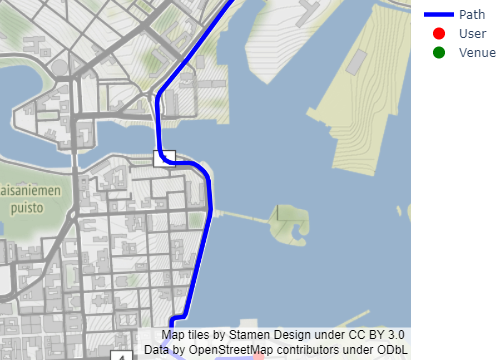

In [39]:
plot_path(lat2, long2, user_point, venue_point)